# A-Band Fitting Using HAPI MultiSpectrum fitting
* Loads packages
* Defines Spectra and Dataset
* Generates parameter and baseline linelists
* Fits Data

In [1]:
## Multi- Spectrum Fitting by Segment

import numpy as np
import numpy.ma as ma
import pandas as pd
import qgrid
import os
from lmfit import minimize, Parameters, report_fit, Model, Minimizer
from lmfit.models import GaussianModel, LinearModel, Model, VoigtModel
import matplotlib.pyplot as plt
from matplotlib import gridspec
from scipy import interpolate

import sys
sys.path.append(r'C:\Users\ema3\Documents\Python Scripts\HAPI')# set location of HAPI.py module
#sys.path.append(r'C:\Users\ema3\Documents\Cold Cavity - O2 A Band')# set location of HAPI.py module
%matplotlib inline
from hapi import *
from HTP_definition_dataframe_190409 import *

import seaborn as sns
sns.set_style("whitegrid")
sns.set_style("ticks")
sns.set_context("poster")


c:\users\ema3\appdata\local\enthought\canopy\edm\envs\user\lib\site-packages\numba\errors.py:105: UserWarning: Insufficiently recent colorama version found. Numba requires colorama >= 0.3.9
  warnings.warn(msg)


HAPI version: 1.1.0.9.6
To get the most up-to-date version please check http://hitran.org/hapi
ATTENTION: Python versions of partition sums from TIPS-2017 are now available in HAPI code

           It is free to use HAPI. If you use HAPI in your research or software development,
           please cite it using the following reference:
           R.V. Kochanov, I.E. Gordon, L.S. Rothman, P. Wcislo, C. Hill, J.S. Wilzewski,
           HITRAN Application Programming Interface (HAPI): A comprehensive approach
           to working with spectroscopic data, J. Quant. Spectrosc. Radiat. Transfer 177, 15-30 (2016)
           DOI: 10.1016/j.jqsrt.2016.03.005


## Load Spectrum

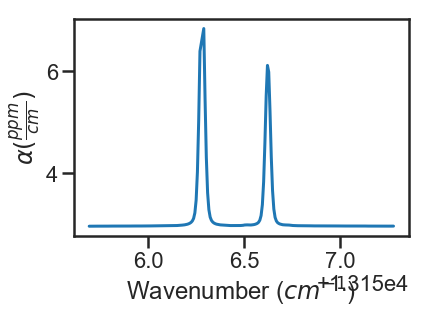

In [10]:
path = r'C:\Users\ema3\Documents\O2 ABand RT - 2019\Intensity Scans\2%\R15Q16 + R17R17' # Location of the Summary Data File
os.chdir(path)

#Generic Fit Parameters
wave_range = 1.5 #range outside of experimental x-range to simulate
IntensityThreshold = 1e-30 #intensities must be above this value to be simulated
Fit_Intensity = 1e-24 #intensities must be above this value for the line to be fit
order_baseline_fit = 1
tau_column = 'Corrected Tau (us)' # Mean tau/us
freq_column = 'Total Frequency (Detuning)' # Total Frequency /MHz
pressure_column = 'Cavity Pressure /Torr'
temperature_column = 'Cavity Temperature Side 2 /C'


#Define all Spectra individually
spec_1 = Spectrum('190510_2per_43_forfit', 
                        concentration = { 7 :0.01949}, natural_abundance = True, diluent = 'air', 
                        etalons = {1:[0.001172, 1.19574]}, 
                        input_freq = True, frequency_column = freq_column,
                        input_tau = True, tau_column = tau_column, tau_stats_column = None, 
                        pressure_column = pressure_column, temperature_column = temperature_column, 
                        nominal_temperature = 296, x_shift = 0.00)
spec_2 = Spectrum('190510_2per_55_forfit', 
                        concentration = { 7 : 0.01949}, natural_abundance = True, diluent = 'air', 
                        etalons = {1:[0.001172, 1.19574]}, 
                        input_freq = True, frequency_column = freq_column,
                        input_tau = True, tau_column = tau_column, tau_stats_column = None, 
                        pressure_column = pressure_column, temperature_column = temperature_column, 
                        nominal_temperature = 296, x_shift = 0.00)
spec_3 = Spectrum('190513_2per_82_forfit', 
                        concentration = { 7 :0.01949}, natural_abundance = True, diluent = 'air', 
                        etalons = {1:[0.001172, 1.19574]}, 
                        input_freq = True, frequency_column = freq_column,
                        input_tau = True, tau_column = tau_column, tau_stats_column = None, 
                        pressure_column = pressure_column, temperature_column = temperature_column, 
                        nominal_temperature = 296, x_shift = 0.00)
spec_4 = Spectrum('190514_2per_126_forfit', 
                        concentration = { 7 :0.01949}, natural_abundance = True, diluent = 'air', 
                        etalons = {1:[0.001172, 1.19574]}, 
                        input_freq = True, frequency_column = freq_column,
                        input_tau = True, tau_column = tau_column, tau_stats_column = None, 
                        pressure_column = pressure_column, temperature_column = temperature_column, 
                        nominal_temperature = 296, x_shift = 0.00)



spec_1.plot_wave_alpha()



## Construct Dataset

In [11]:
#Add all spectrum to a Dataset object
SPECTRA = Dataset([spec_1, spec_2, spec_3, spec_4], 'Line Intensity', baseline_order = order_baseline_fit)

#Generate Baseline Parameter list based on number of etalons in spectra definitions and baseline order
BASE_LINELIST = SPECTRA.generate_baseline_paramlist()
#BASE_LINELIST = pd.read_csv('Line Intensity_baseline_paramlist.csv')

#Read in Possible linelists
hapi = r'C:\Users\ema3\Documents\Python Scripts\HAPI'
os.chdir(hapi)
PARAM_LINELIST = pd.read_csv('Drouin_2017_linelist.csv')



## Generate Fit Parameter Files

In [13]:
os.chdir(path)
# Set-up for Fitting
#lineprofile = 'NGP' #VP, SDVP, NGP, SDNGP, HTP


  

FITPARAMS = Generate_FitParam_File(SPECTRA, PARAM_LINELIST, BASE_LINELIST, lineprofile = 'SDVP', linemixing = False, 
                                  fit_intensity = Fit_Intensity, threshold_intensity = IntensityThreshold, sim_window = wave_range,
                                  nu_constrain = False, sw_constrain = False, gamma0_constrain = True, delta0_constrain = True, 
                                   aw_constrain = True, as_constrain = True, 
                                   nuVC_constrain = True, eta_constrain =True, linemixing_constrain = True)

FITPARAMS.generate_fit_param_linelist_from_linelist(vary_nu = {7:{1:True, 2:False, 3:False}}, vary_sw = {7:{1:True, 2:False, 3:False}},
                                                    vary_gamma0 = {7:{1: True, 2:False, 3: False}, 1:{1:False}}, vary_n_gamma0 = {7:{1:True}}, 
                                                    vary_delta0 = {7:{1: False, 2:False, 3: False}, 1:{1:False}}, vary_n_delta0 = {7:{1:True}}, 
                                                    vary_aw = {7:{1: True, 2:False, 3: False}, 1:{1:False}}, vary_n_gamma2 = {7:{1:False}}, 
                                                    vary_as = {}, vary_n_delta2 = {7:{1:False}}, 
                                                    vary_nuVC = {7:{1:False}}, vary_n_nuVC = {7:{1:False}},
                                                    vary_eta = {}, vary_linemixing = {7:{1:False}})

FITPARAMS.generate_fit_baseline_linelist(vary_baseline = True, vary_concentration = {7:False, 1:False}, vary_xshift = False, 
                                      vary_etalon_amp= True, vary_etalon_freq= False, vary_etalon_phase= True)





,Concentration_O2,Concentration_O2_err,Concentration_O2_vary,baseline_a,baseline_a_err,baseline_a_vary,baseline_b,baseline_b_err,baseline_b_vary,etalon_1_amp,...,etalon_1_amp_vary,etalon_1_freq,etalon_1_freq_err,etalon_1_freq_vary,etalon_1_phase,etalon_1_phase_err,etalon_1_phase_vary,x_shift,x_shift_err,x_shift_vary
Spectrum Number,,,,,,,,,,,,,,,,,,,,,
1.0,0.01949,0,False,2.957091,0,True,0.0,0,True,0.001172,...,True,1.19574,0,False,0.0,0,True,0.0,0,False
2.0,0.01949,0,False,2.959480,0,True,0.0,0,True,0.001172,...,True,1.19574,0,False,0.0,0,True,0.0,0,False
3.0,0.01949,0,False,2.956829,0,True,0.0,0,True,0.001172,...,True,1.19574,0,False,0.0,0,True,0.0,0,False
4.0,0.01949,0,False,2.949260,0,True,0.0,0,True,0.001172,...,True,1.19574,0,False,0.0,0,True,0.0,0,False


In [ ]:
edit_files = Edit_Fit_Param_Files('Baseline_LineList', 'Parameter_LineList')
edit_baseline = edit_files.edit_generated_baselist()
edit_baseline

In [9]:
edit_params = edit_files.edit_generated_paramlist()
edit_params

QgridWidget(grid_options={'fullWidthRows': True, 'editable': True, 'minVisibleRows': 8, 'explicitInitializatio…

In [ ]:
edit_files.save_editted_baselist(edit_baseline)
edit_files.save_editted_paramlist(edit_params)
print ('')

Name                     Value      Min      Max   Stderr     Vary     Expr Brute_Step
Concentration_O2_1     0.01949  0.01772  0.02144        0    False     None     None
Concentration_O2_2     0.01949  0.01772  0.02144        0    False     None     None
Concentration_O2_3     0.01949  0.01772  0.02144        0    False     None     None
Concentration_O2_4     0.01949  0.01772  0.02144        0    False     None     None
SD_delta_air_line_11         0     -inf      inf        0    False     None     None
SD_delta_air_line_15         0     -inf      inf        0    False     None     None
SD_delta_air_line_2          0     -inf      inf        0    False     None     None
SD_delta_air_line_24         0     -inf      inf        0    False     None     None
SD_delta_air_line_27         0     -inf      inf        0    False     None     None
SD_delta_air_line_39         0     -inf      inf        0    False     None     None
SD_delta_air_line_40         0     -inf      inf        0    Fa

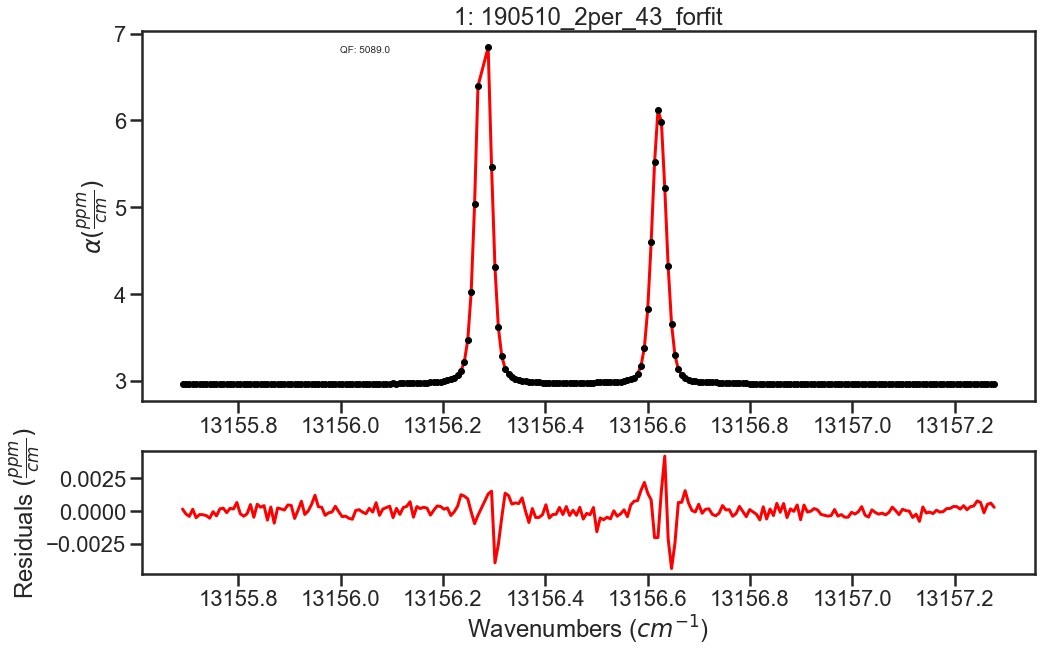

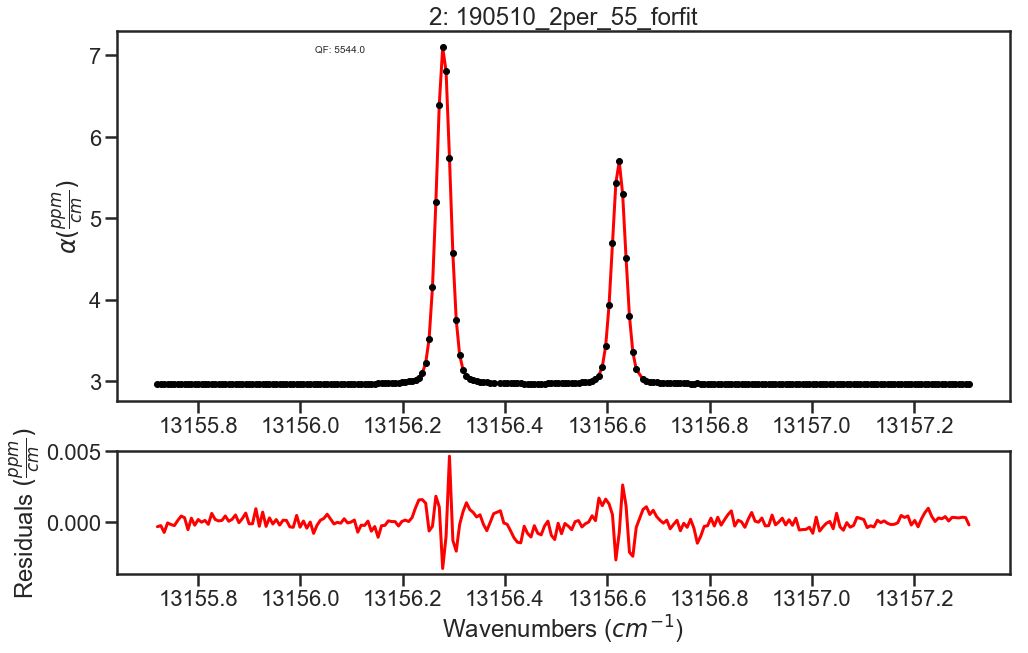

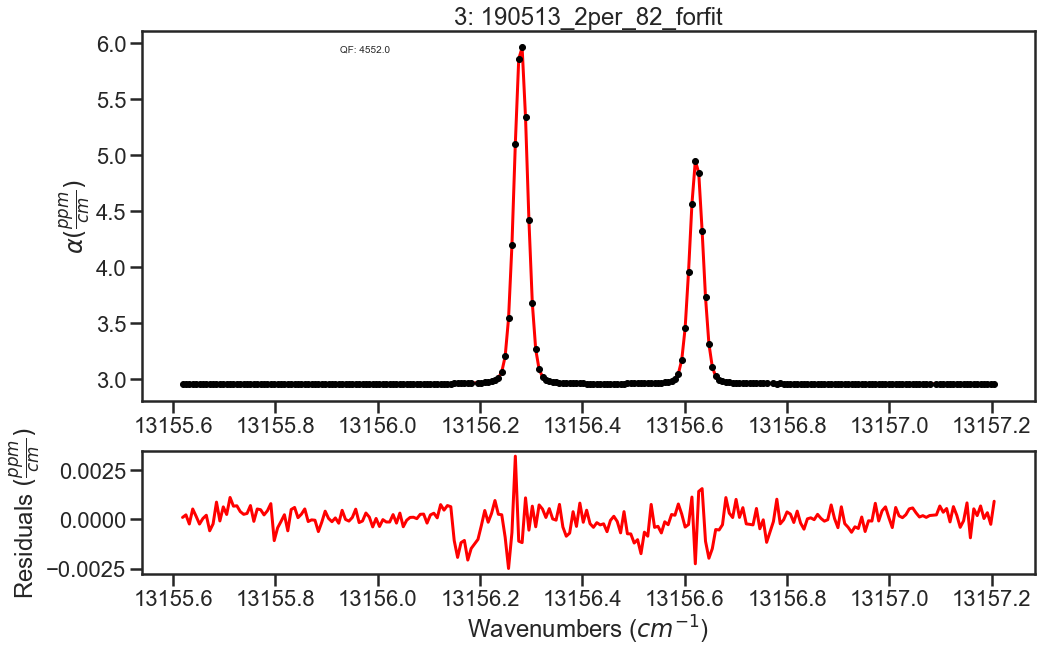

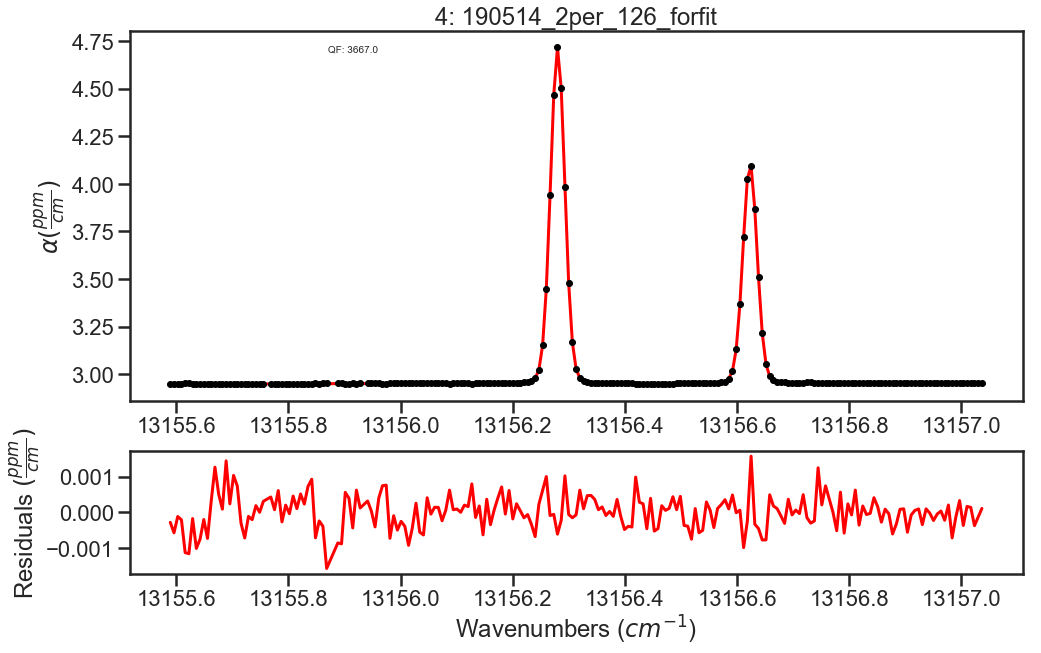

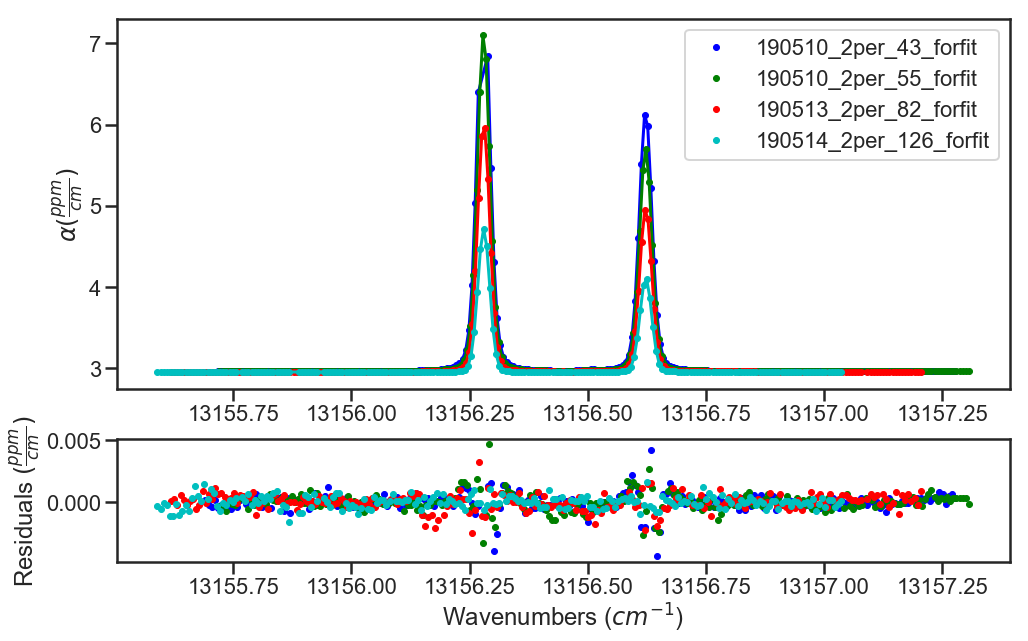

In [6]:
os.chdir(path)   
fit_data = Fit_DataSet(SPECTRA,'Baseline_LineList', 'Parameter_LineList', fit_intensity = Fit_Intensity, 
                baseline_limit = False, baseline_limit_factor = 10, 
                concentration_limit = True, concentration_limit_factor = 1.1, 
                etalon_limit = False, etalon_limit_factor = 2, #phase is constrained to +/- 2pi, 
                x_shift_limit = True, x_shift_limit_magnitude = 0.5, 
                nu_limit = True, nu_limit_magnitude = 0.1, 
                sw_limit = True, sw_limit_factor = 2, 
                gamma0_limit = True, gamma0_limit_factor = 3, n_gamma0_limit= False, n_gamma0_limit_factor = 50, 
                delta0_limit = True, delta0_limit_factor = 2, n_delta0_limit = False, n_delta0_limit_factor = 50, 
                SD_gamma_limit = True, SD_gamma_limit_factor = 2, n_gamma2_limit = False, n_gamma2_limit_factor = 50, 
                SD_delta_limit = True, SD_delta_limit_factor = 50, n_delta2_limit = False, n_delta2_limit_factor = 50, 
                nuVC_limit = False, nuVC_limit_factor = 2, n_nuVC_limit = False, n_nuVC_limit_factor = 50, 
                eta_limit = True, eta_limit_factor = 50, linemixing_limit = False, linemixing_limit_factor = 50)
params = fit_data.generate_params()
#params['etalon_2_freq_1'].set(expr='2*etalon_1_freq_1')
#params['etalon_2_phase_1'].set(expr='etalon_1_phase_1')


for param in params:
    if 'n_gamma2' in param:
        newparam = param.replace('n_gamma2', 'n_gamma0')
        params[param].set(expr = newparam)



#print (params)

#add_expr_params(self, params, param_name, expr)

result = fit_data.fit_data(params, wing_cutoff = 25, wing_wavenumbers = 1)
print (result.params.pretty_print())

fit_data.residual_analysis(result, indv_resid_plot=True)
fit_data.update_params(result)
SPECTRA.generate_summary_file(save_file = True)
SPECTRA.plot_model_residuals()




C:\Users\ema3\Documents\Python Scripts\HAPI\HTP_definition_dataframe_190409.py:433: RuntimeWarning: divide by zero encountered in true_divide
  FFT['Freq (cm-1)'] = 1 / fft_freq
C:\Users\ema3\Documents\Python Scripts\HAPI\HTP_definition_dataframe_190409.py:441: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(1 / fft_freq, fft_amplitude, '-')


    Frequency  Amplitude     Phase  Freq (cm-1)
0    7.708447   0.000169  2.339312     0.129728
1   72.879863   0.000137 -1.474927     0.013721
2    8.409215   0.000135  0.915785     0.118917
3    2.102304   0.000133 -2.335742     0.475669
4    9.109983   0.000122  0.385144     0.109770
5   48.352986   0.000120  1.193337     0.020681
6    4.905375   0.000114  2.465161     0.203858
7   24.526877   0.000112  1.449350     0.040772
8   63.069113   0.000112  2.731671     0.015856
9   12.613823   0.000112 -0.853156     0.079278
10  30.133020   0.000110 -2.447588     0.033186
11  14.015358   0.000107 -1.205036     0.071350
12  15.416894   0.000106  2.476006     0.064864
13  23.826109   0.000102 -0.994478     0.041971
14  40.644539   0.000101  1.262874     0.024604
15  47.652218   0.000100  2.164592     0.020985
16  50.455290   0.000100  0.682598     0.019820
17  33.636860   0.000096  0.608221     0.029729
18  53.959130   0.000092 -1.451222     0.018533
19  32.235324   0.000085  2.787884     0

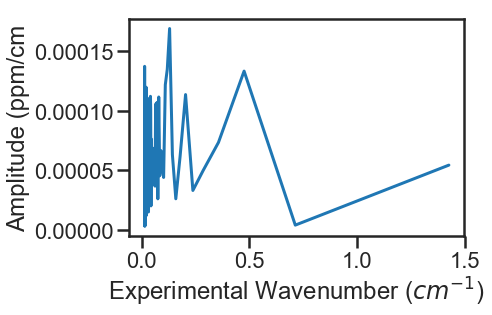

60.12449576029999 24.753745681682346
49.82397842219999 24.75824458315128
34.973163754299996 24.72630335002532
18.912206300500003 24.714909894025595


In [7]:
spec_4.fft_spectrum()


s_list = [spec_1, spec_2, spec_3, spec_4]
for s in s_list:
    
    print (s.get_pressure_torr(), s.get_temperature_C())



